### From point clouds to graphs

## Miguel Vaz

### Düsseldorf, 28th October 2015

# About me

Finance pays my bills

d-fine
360 T

PhD in Robotics (speech interaction with a humanoid) brought me there
Honda Research Institute Europe

@migueljvaz

I don't like "Alt"

<div class="col-xs-1"><h1>I</h1></div>
<div class="col-xs-2">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f1/Heart_coraz%C3%B3n.svg/75px-Heart_coraz%C3%B3n.svg.png"/>
</div>
<div class="col-xs-6"><h1>networks</h1></div>

say something

# Why?

Networks give us a way to quantify and reason about concepts that are already familiar to us.

"Frankfurt airport is an international hub"

"Lehman was too central to fail"

"Thomas Wiecki is a well connected data scientist"

![](http://ecx.images-amazon.com/images/I/71qAmSP21wL.jpg)

Mention paper from PyData 2014

In [1]:
# preparation

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.display import  display, display_html

# Part 1: point clouds

Let's assume a well behaved dataset, with points selected from either of the following distributions

$X_1 \sim N\left( \mu=(1,1),\, \sigma^2=(0.9, 0.9) \right)$

$X_2 \sim N\left( \mu=(-0.5,0),\, \sigma^2=(0.9, 0.9) \right)$

$X_3 \sim N\left( \mu=(1,-1),\, \sigma^2=(0.9, 0.9) \right)$

Well-behaved means in this case that it is described by almost non-overlaping centroids.


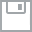
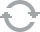
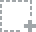
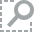
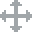
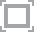
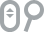
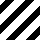
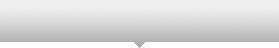
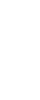
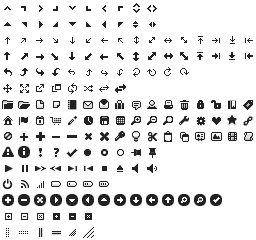
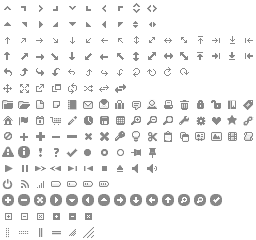
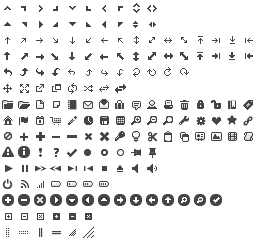
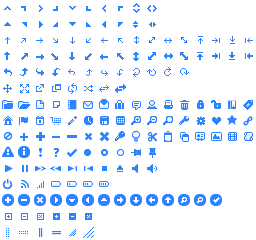
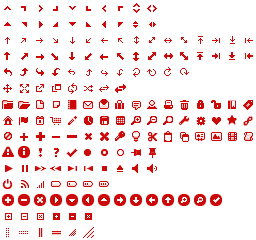
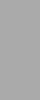
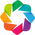
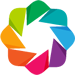

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import output_notebook, figure, show, ColumnDataSource
TOOLS="resize,crosshair,pan,wheel_zoom,box_zoom,reset,tap,previewsave,box_select,poly_select,lasso_select"
output_notebook()

In [5]:
from kmeans_aux import *

In [6]:
from sympy import *
init_printing(use_unicode=True)

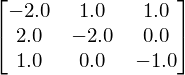

In [7]:
m = Matrix(np.matrix([[-2,1,1], [2,-2,0], [1,0,-1]]) )
m

In [8]:
X, labels_true, centres = generate_three_circles()
src = create_datasource(X, labels_true, centres)

In [9]:
p = figure(tools=TOOLS);
p.scatter('x', 'y', radius='radius', color='fill_color', source=src);
show(p)

## K-Means

One possible way of recovering the categories is by using the K-Means clustering algorithm.

The $k$-means uses $k$ centroids to define clusters.
It finds the best centroids by alternating between

1. assigning data points to clusters based on the current centroids
2. chosing centroids (points which are the center of a cluster) based on the current assignment of data points to clusters.

![xxx](pics/kmeans.png)

Picture taken from [this website](http://stanford.edu/~cpiech/cs221/handouts/kmeans.html) by Chris Piech.

1. Initialize cluster centroids $\mu_1, \mu_2, \ldots, \mu_k \in \mathcal{R}^n$ (randomly)
2. Repeat until convergence : {

    For every $i$, set $$c^{(i)} := arg \min_{j} || x^(i) - \mu_j ||^2$$

    For each $j$, set $$\mu_j := \frac{\sum_{i=1}^m 1_{c^(i) = j}x^(i) }{\sum_{i=1}^m 1_{c^(i) = j}x^(i)}$$
}

Scikit-learn already has an implementation of the algorithm

In [10]:
k_means_3_labels, k_means_3_cluster_centres = do_kmeans(X, n_clusters=3)
distance, order, is_correct = compare_kmeans_with_prior(k_means_3_cluster_centres, k_means_3_labels, centres, labels_true)

In [11]:
# part the plot
alpha = 0.9  - is_correct * 0.8
rad = src.data['radius'] * (1 + (~ is_correct * 1))
src.add(rad, 'radius2')
src.add(alpha, name='alpha' )

'alpha'

In [12]:
p = figure(tools=TOOLS);
p.scatter('x', 'y', color='fill_color', alpha='alpha', radius='radius2', source=src);
show(p)

# Part 2: graphs

Let's assume a different dataset, with points selected from either of the following distributions.

In [13]:
X, true_labels = generate_two_moons()
p = figure(tools=TOOLS);
x,y = [list(t) for t in zip(*X)]
p.scatter(x, y, color='black', radius=0.02);
show(p)

The distribution is no longer described by centroids.

K-Means does not capture the non-linearity of the dataset structure

In [14]:
k_means_2_labels, k_means_2_cluster_centres = do_kmeans(X, n_clusters=2, n_init=10)
src2 = create_datasource(X, k_means_2_labels, k_means_2_cluster_centres)

In [15]:
p = figure(tools=TOOLS);
p.scatter('x', 'y', color='fill_color', source=src2);
# alpha='alpha', radius='radius', 
show(p)

# Other solutions?

### Neural Network

### Project the dataset into a different space (Support Vector Machine)

### Any suggestions?




### We will look at Spectral Clustering

# Spectral Clustering

Takes only into account the local structure of the data.

Makes use of the concept of similarity, more general than that of distance.

Uses important results on the eigenvectors of the Laplacian of the similarity matrix, and clusters on a lower dimensionsional space.


### Unnormalized spectral clustering

#### Input:
- Similarity matrix $S \in R^{n \times n}$
- number $k$ of clusters to construct


#### Algorithm:
- Construct a similarity graph
$A$

- Let $W$ be its weighted adjacency matrix.

- Compute the unnormalized Laplacian
$L = D - A$

- Compute the first $k$ eigenvectors $u_1, \ldots, u_k$ of $L$

- Let $U \in R^{n \times k}$ be the matrix containing the vectors $u_1, \ldots, u_k$ as columns

- For $i = 1,\ldots, n$, let $y_i \in R^k$ be the vector corresponding to the i-th row of U
- Cluster the points $(y_i)_{i=1,\ldots,n}$ in $R^k$ with the k-means algorithm into clusters $C_1,\ldots,C_k$

#### Output:
Clusters $A_1,\ldots,A_k$ with $A_i = \{ j | y_j \in C_i\}

## Similarity matrix / graph

Following similarity graphs can be defined

**$\epsilon-$neighborhood graph**
connects all points whose pairwise distances are smaller than $\epsilon$



**$k$-nearest neighbor graphs**
connects $v_i$ and $v_j$ if $v_j$ is among the $k$ nearest points of $k_i$


**fully connected graph**
outsources the locality modelling to the similarity function, such as
$s(x_i, x_j) = \exp\left( - \frac{|| x_i - x_j||^2}{ 2 \sigma^2} \right)$

### No full metric is required! E.g. it is possible to compare time-series based on their correlation, probability distributions, or strings on edit distance



In [16]:
distance = euclidean_distances(X,X,squared=True)

sig = 0.5
# Turn the distance into a similarity by applying a Gaussian kernel
similarity = np.exp(-distance/sig)

/usr/local/anaconda/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>


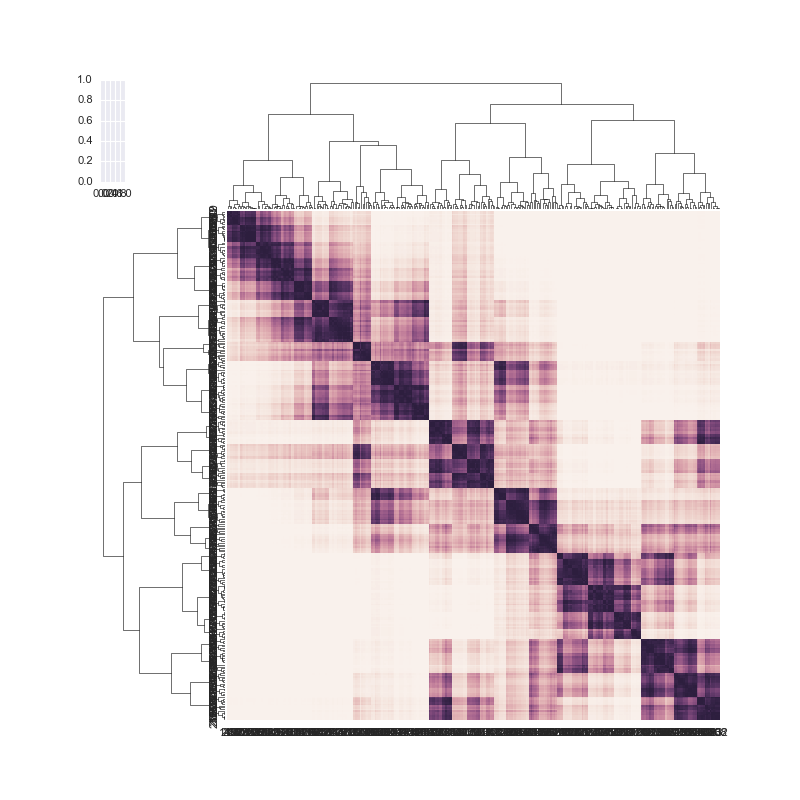

/usr/local/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [17]:
%matplotlib notebook

sns.clustermap(similarity)

# plt.figure(figsize=(10, 10))

# plt.imshow(similarity)


In [18]:
def create_adjacency_matrix(similarity, num_neighbours=5):
    A = ( np.ones(similarity.shape) - np.eye(similarity.shape[0])) * similarity
    for i in range(A.shape[0]):
        s = np.sort(A[i])
        s = s[::-1] #reverse order
        A[i][A[i]<s[num_neighbours]] = 0
    A = np.fmax(A, A.T)
    return A

In [20]:
A = create_adjacency_matrix(similarity, num_neighbours=10)

# Calculate the degree - the sum of all incoming weights to a vertex
D = np.diag(np.sum(A, axis=0))

# Un-normalised Laplacian Matrix
L = D - A

<IPython.core.display.Javascript object>


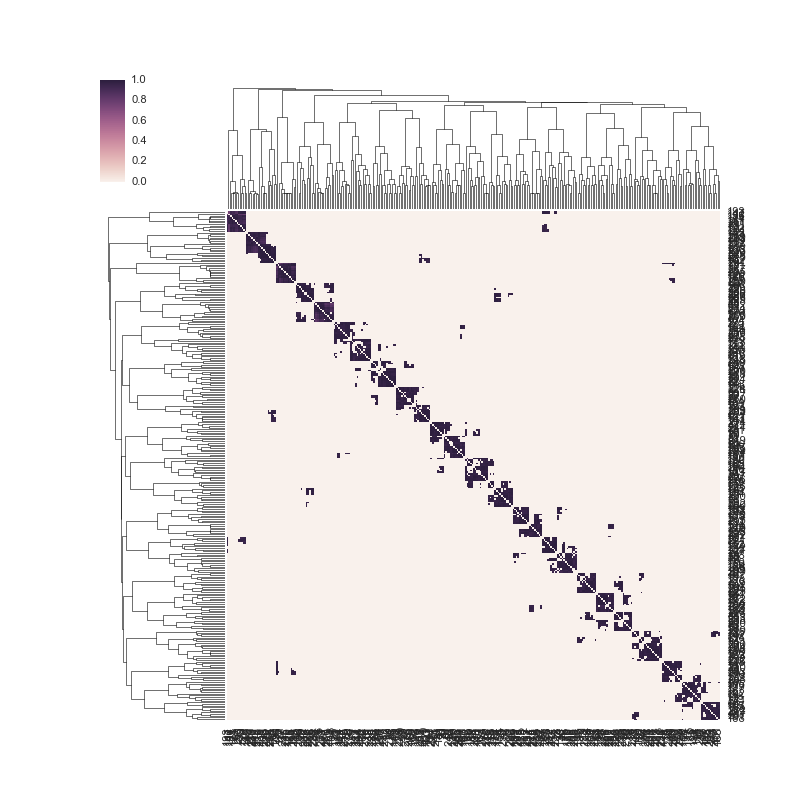

/usr/local/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [25]:
%matplotlib notebook

sns.clustermap(create_adjacency_matrix(similarity, num_neighbours=10))

In [32]:
import networkx as nx
g = nx.from_numpy_matrix(A)

In [22]:
# Perform an Eigenvalue deccomposition
from scipy.linalg import eig
[eig_vals, eig_vecs] = eig(L)

sorted_inds = np.argsort(eig_vals.real, axis=0)


In [27]:
F = eig_vecs[:,sorted_inds[0:3]]


<IPython.core.display.Javascript object>


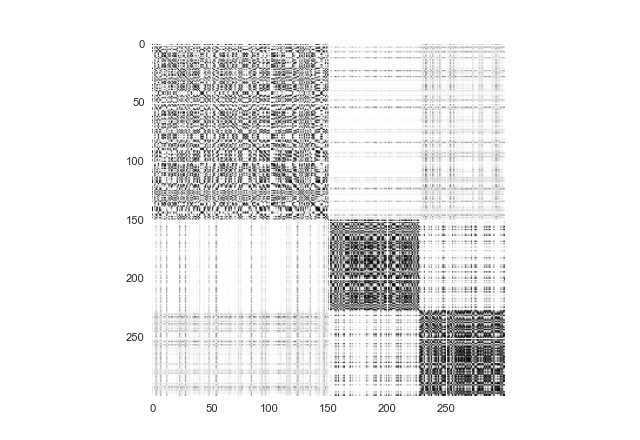

In [28]:
%matplotlib notebook
# Now perform k-means in this more amenable space
k_means_3 = KMeans(init='k-means++', n_clusters=3, n_init=10)
k_means_3.fit(F)
k_means_3_labels = k_means_3.labels_
k_means_3_cluster_centers = k_means_3.cluster_centers_

ind_3 = np.argsort(k_means_3_labels)

plt.imshow(similarity[ind_3].T[ind_3])


In [ ]:
%matplotlib inline
plt.plot(F[:,0] * F[:,1])

In [ ]:
%matplotlib notebook
plt.bar(range(10), eig_vals.real[sorted_inds[0:10]])


In [ ]:
from d3networkx import EventfulGraph, ForceDirectedGraph, empty_eventfulgraph_hook

In [ ]:
from networkx.generators import random_graphs
from networkx.generators import classic

In [ ]:
def handle_graph(graph):
    print(graph.graph._sleep)
    graph_widget = ForceDirectedGraph(graph, width=600, height=500)
    display(graph_widget)
EventfulGraph.on_constructed(handle_graph)
random_graphs.empty_graph = empty_eventfulgraph_hook(sleep=0.01)

In [33]:
g = random_graphs.powerlaw_cluster_graph(70, 3, 0.7);

NameError: name 'random_graphs' is not defined

In [ ]:
g.node[1]['fill'] = '#770000'